##Appendix 2

### Summarizing News Article with LSTM deep learning model

The objective of this project is to build a model that can create relevant summaries for news articles.

To build our model we will use a two-layered bidirectional RNN with LSTMs on the input data and two layers, each with an LSTM using bahdanau attention on the target data. Jaemin's tutorial for seq2seq was really helpful to get the code in working order

The sections of this project are:

Inspecting the Data
Preparing the Data
Building the Model
Training the Model
Making Our Own Summaries

In [ ]:
#!pip install tensorflow
#!pip install tensorflow_addons

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 2.11.0


Insepcting the Data

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# import locale
# print(locale.getpreferredencoding())

In [ ]:

# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [ ]:
!ls "gdrive/My Drive/Analytics Lab_INDENG 243 - Project/Module 2/"

 df_merged.csv		    'Module_2_Final Presentation.pptx'
 Fine_Tuned_DL_Model.ipynb   Module2Pres_content.gslides
 model0.pt		     my_model
 model_1000.pt		     reviews.csv
 model2.pt		     Temp_tf1.11.ipynb
 model3.pt		     test.ipynb
 model.pt		     Train_Data_Prep_For_DL.ipynb


In [ ]:
reviews = pd.read_csv('gdrive/MyDrive/Analytics Lab_INDENG 243 - Project/Module 2/df_merged.csv')

In [ ]:
reviews.shape

(6649, 3)

In [ ]:
reviews.head(10)

,Unnamed: 0,Text,Summary
0,0,"This post is part of Polyarchy, an independent...",['In the wake of a New York Times article sugg...
1,1,The Indianapolis Colts made Andrew Luck the h...,['The Indianapolis Colts made Andrew Luck the ...
2,2,"DAVOS, Switzerland (Reuters) - U.S. President ...","[""The special counsel investigating alleged Ru..."
3,3,PARIS (Reuters) - Former French president Nico...,['Sarkozy has retired twice from politics - th...
4,4,Paris Hilton arrived at LAX Wednesday dressed ...,['Paris Hilton arrived at LAX Wednesday dresse...
5,5,"BERLIN, June 17 (Reuters) - ECB board member B...",['The European Central Bank could introduce a ...
6,6,CARACAS (Reuters) - Venezuelan authorities hav...,['The arrests come nearly two months after a f...
7,7,If only every day could be like this. You can’...,['You wake up in the morning and you’re in the...
8,8,"Google I/O, the company's big developer confer...","[""It's one of the most important weeks of the ..."
9,9,China is dismissing unfavorable media reports ...,['China is dismissing media reports as fake ne...


Step 2: Cleaning the Data
The data you procured can have non-alphabetic characters which you can remove before training the model. To do this, you can use the re (Regular Expressions) library.



In [ ]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):

    for row in column:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

Call the text_strip() function on both the text and summary.

In [ ]:
processed_text = text_strip(reviews['Text'])
processed_summary = text_strip(reviews['Summary'])

Load the data as batches using the pipe() method provided by spaCy. This ensures that all pieces of text and summaries possess the string data type.

In [ ]:
import spacy
from time import time

nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser']) 

# Process text as batches and yield Doc objects in order
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=6000)]

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=5000)]

In [ ]:
summary[0]

The _START_ and _END_ tokens denote the start and end of the summary, respectively. This will be used later to detect and remove empty summaries.

Now let's print some of the data to understand how it’s been loaded.

In [ ]:
reviews['cleaned_text'] = pd.Series(text)
reviews['cleaned_summary'] = pd.Series(summary)

In [ ]:
from google.colab import files
reviews.to_csv('reviews.csv', encoding = 'utf-8-sig')

In [ ]:
files.download('reviews.csv')

In [ ]:
reviews = pd.read_csv('/content/gdrive/My Drive/Analytics Lab_INDENG 243 - Project/Module 2/reviews.csv')

Step 3: Determining the Maximum Permissible Sequence Lengths
Next, store the text and summary lists in pandas objects.

In [ ]:
reviews = reviews[0:6000]
reviews = reviews.drop('Unnamed: 0.2', axis=1)
reviews = reviews.drop('Unnamed: 0.1', axis=1)
reviews = reviews.drop('Unnamed: 0', axis=1)

In [ ]:
reviews.head()

,Text,Summary,cleaned_text,cleaned_summary
0,"This post is part of Polyarchy, an independent...",['In the wake of a New York Times article sugg...,this post is part of polyarchy an independent ...,_START_ in the wake of new york times article...
1,The Indianapolis Colts made Andrew Luck the h...,['The Indianapolis Colts made Andrew Luck the ...,the indianapolis colts made andrew luck the h...,_START_ the indianapolis colts made andrew lu...
2,"DAVOS, Switzerland (Reuters) - U.S. President ...","[""The special counsel investigating alleged Ru...",davos switzerland reuters u.s president donald...,_START_ the special counsel investigating all...
3,PARIS (Reuters) - Former French president Nico...,['Sarkozy has retired twice from politics - th...,paris reuters former french president nicolas ...,_START_ sarkozy has retired twice from politi...
4,Paris Hilton arrived at LAX Wednesday dressed ...,['Paris Hilton arrived at LAX Wednesday dresse...,paris hilton arrived at lax wednesday dressed ...,_START_ paris hilton arrived at lax wednesday...


Ploting graph to determine the frequency ranges tied to the lengths of text and summary, i.e., determine the range of length of words where the maximum number of texts and summaries fall into.



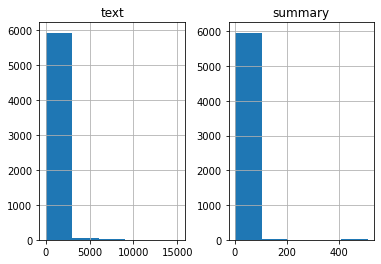

In [ ]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in reviews['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in reviews['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

From the graphs, you can determine the range where the maximum number of words fall into. For summary, you can assign the range to be 0-200.

To find the range of text which we aren't able to clearly decipher from the graph, consider a random range and find the percentage of words falling into that range.

In [ ]:
# Check how much % of text have 0-100 words
cnt = 0
for i in reviews['cleaned_text']:
    if len(i.split()) <= 2000:
        cnt = cnt + 1
print(cnt / len(reviews['cleaned_text']))

0.9625


As you can observe, 96% of the text pieces fall into the 0-2000 category.

Now initialize the maximum permissible lengths of both text and

In [ ]:
# Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len = 2000
max_summary_len = 100

## Step 4: Selecting Plausible Texts and Summaries

Select texts and summaries which are below the maximum lengths as defined in Step 3.

In [ ]:
# Select the Summaries and Text which fall below max length 

import numpy as np

cleaned_text = np.array(reviews['cleaned_text'])
cleaned_summary= np.array(reviews['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

post_pre.head(2)

,text,summary
0,davos switzerland reuters u.s president donald...,_START_ the special counsel investigating all...
1,paris reuters former french president nicolas ...,_START_ sarkozy has retired twice from politi...


In [ ]:
post_pre.describe()
# post_pre = post_pre[0:2000]
# post_pre

,text,summary
count,5737,5737
unique,5721,5307
top,advertise on hyperallergic with nectar ads,_START_ all images are copyrighted _END_
freq,8,191


Now we add start of the sequence (sostok) and end of the sequence (eostok) to denote start and end of the summaries, respectively. This shall be useful to trigger the start of summarization during the inferencing phase.

In [ ]:
# Add sostok and eostok

post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')

post_pre.head(2)

,text,summary
0,davos switzerland reuters u.s president donald...,sostok _START_ the special counsel investigat...
1,paris reuters former french president nicolas ...,sostok _START_ sarkozy has retired twice from...


## Step 5: Tokenizing the Text
First split the data into train and test data chunks.

In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [ ]:
x_tr[9]

'beto rourke doesn buy the criticism of beyonce that she waited too long to throw her support behind him in the texas senatorial election to the contrary he says it hard to find anything from houston more impressive than her we got beto on capitol hill and he can say enough about bey can say enough because he interrupted by slew of fans who went nuts when they saw him as for beyonce some of beto supporters think it was too little too late throwing her support behind him on the day of the election gotta say he about as genuine as they come unspotted by the ever-present phoniness of politics the video fun to watch.'

In [ ]:
y_tr[9]

'sostok _START_  beto rourke doesn buy the criticism of beyonce that she waited too long to throw her support behind him in the texas senatorial election to the contrary he says it hard to find anything from houston more impressive than her beto rourke doesn buy the criticism of beyonce that she waited too long to throw her support behind him in the texas senatorial election to the contrary he says it hard to find anything from houston more impressive than her  _END_ eostok'

Preparing and tokenizing the text data.

In [ ]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

Finding the percentage of occurrence of rare words (say, occurring less than 5 times) in the text.

In [ ]:
thresh = 2

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  42.752957038671326


Tokenizing the text again by considering the total number of words minus the rare occurrences. Convert text to numbers and pad them all to the same length.

In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 46706


Doing the same for the summaries as well.

In [ ]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 1

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt - cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 0.0
Size of vocabulary in Y = 12898


## Step 6: Removing Empty Texts and Summaries
Removing all empty summaries (which only have START and END tokens) and their associated texts from the data.

In [ ]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

Repeating the same for the validation data as well

In [ ]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

## Step 7: Creating the Model
First, we defined the Encoder and Decoder networks.

Encoder
The input length that the encoder accepts is equal to the maximum text length which we’ve already estimated in Step 3. This is then given to an Embedding Layer of dimension (total number of words captured in the text vocabulary) x (number of nodes in an embedding layer)  (calculated in Step 5; the x_voc variable). This is followed by three LSTM networks wherein each layer returns the LSTM output, as well as the hidden and cell states observed at the previous time steps.

Decoder
In the decoder, an embedding layer is defined followed by an LSTM network. The initial state of the LSTM network is the last hidden and cell states taken from the encoder. The output of the LSTM is given to a Dense layer wrapped in a TimeDistributed layer with an attached softmax activation function.

Altogether, the model accepts encoder (text) and decoder (summary) as input and it outputs the summary. The prediction happens through predicting the upcoming word of the summary from the previous word of the summary (see the below figure).


Consider the summary line to be “I want every age to laugh”. The model has to accept two inputs - the actual text and the summary. During the training phase, the decoder accepts the input summary given to the model, and learns every word that has to follow a certain given word. It then generates the predictions using an inference model during the test phase.
Add the following code to define your network architecture.

In [ ]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.1,
                     recurrent_dropout=0.1)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.1,
                     recurrent_dropout=0.1)
(encoder_outputs, state_h, state_c) = encoder_lstm2(encoder_output1)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.1,
                    recurrent_dropout=0.1)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 2000, 200)    9341200     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 2000, 300),  601200      ['embedding[0][0]']              
                                 (None, 300),                                                 

## Step 8: Training the Model
In this step, we compiled the model and define EarlyStopping to stop training the model once the validation loss metric has stopped decreasing.

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

Next, we use the model.fit() method to fit the training data where you can define the batch size to be 128. Send the text and summary (excluding the last word in summary) as the input, and a reshaped summary tensor comprising every word (starting from the second word) as the output (which explains the infusion of intelligence into the model to predict a word, given the previous word). Besides, to enable validation during the training phase, we sent the validation data as well.

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=30,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/30
7/7 [==============================] - 89s 13s/step - loss: 1.4358 - val_loss: 1.1166
Epoch 2/30
7/7 [==============================] - 89s 13s/step - loss: 1.4339 - val_loss: 1.1084
Epoch 3/30
7/7 [==============================] - 88s 13s/step - loss: 1.4306 - val_loss: 1.1070
Epoch 4/30
7/7 [==============================] - 89s 13s/step - loss: 1.4270 - val_loss: 1.1054
Epoch 5/30
7/7 [==============================] - 89s 13s/step - loss: 1.4249 - val_loss: 1.1025
Epoch 6/30
7/7 [==============================] - 89s 13s/step - loss: 1.4230 - val_loss: 1.1052
Epoch 7/30
7/7 [==============================] - 89s 13s/step - loss: 1.4212 - val_loss: 1.1010
Epoch 8/30
7/7 [==============================] - 89s 13s/step - loss: 1.4185 - val_loss: 1.1037
Epoch 9/30
7/7 [==============================] - 89s 13s/step - loss: 1.4177 - val_loss: 1.0991
Epoch 10/30
7/7 [==============================] - 89s 13s/step - loss: 1.4144 - val_loss: 1.0989
Epoch 11/30
7/7 [============

In [ ]:
#model.save('gdrive/MyDrive/Analytics Lab_INDENG 243 - Project/Module 2/my_model')


#reconstructed_model = keras.models.load_model('gdrive/MyDrive/Analytics Lab_INDENG 243 - Project/Module 2/my_model'"my_model')

reconstructed_model = keras.models.load_model('gdrive/MyDrive/Analytics Lab_INDENG 243 - Project/Module 2/my_model')

Next, we plot the training and validation loss metrics observed during the training phase.

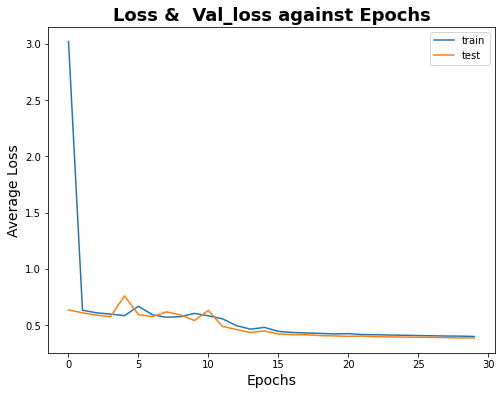

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title('Loss &  Val_loss against Epochs', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Average Loss', fontsize=14)
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')

ax.legend()
plt.show()

Step 9: Generating Predictions
Now that we've trained the model, to generate summaries from the given pieces of text, first we reverse map the indices to the words (which has been previously generated using texts_to_sequences in Step 5). Also, we map the words to indices from the summaries tokenizer which is to be used to detect the start and end of the sequences.



In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

Now we define the encoder and decoder inference models to start making the predictions. we used tensorflow.keras.Model() object to create your inference models.

An encoder inference model accepts text and returns the output generated from the three LSTMs, and hidden and cell states. A decoder inference model accepts the start of the sequence identifier (sostok) and predicts the upcoming word, eventually leading to predicting the whole summary.

In [ ]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

Now we define a function decode_sequence() which accepts the input text and outputs the predicted summary. Start with sostok and continue generating words until eostok is encountered or the maximum length of the summary is reached. Predict the upcoming word from a given word by choosing the word which has the maximum probability attached and update the internal state of the decoder accordingly.

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

Define two functions - seq2summary() and seq2text() which convert numeric-representation to string-representation of summary and text respectively.

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

Finally, generating the predictions by sending in the text.

In [ ]:
# for i in range(0, 10):
#     print ('Review:', seq2text(x_val[i]))
#     print ('Original summary:', seq2summary(y_val[i]))
#     print ('Predicted summary:', decode_sequence(x_val[i].reshape(1,
#            max_text_len)))
#     print ('\n')


In [ ]:
Article = seq2text(x_val[14])
Original_summary = seq2summary(y_val[14])
Predicted_summary = decode_sequence(x_val[14].reshape(1, max_text_len))

1/1 [==============================] - 0s 22ms/step


In [ ]:
# print ('Article:', Article)
# print ('Original summary:', Original_summary)
# print ('Predicted summary:', Predicted_summary)

from IPython.display import HTML
HTML("""
<style>
.output {
    overflow-x: auto !important;
}
</style>
""")


# Print the article and generated summary, wrapping them in HTML for readability
print('Article:')
display(HTML('<div style="white-space: pre-wrap;">' + Article + '</div>'))
print('\n')
print('Original summary:')
display(HTML('<div style="white-space: pre-wrap;">' + Original_summary + '</div>'))
print('\n')
display(HTML('<div style="white-space: pre-wrap;">' + Predicted_summary + '</div>'))
print('\n')

Article:




Original summary:


In [ ]:
#installing rouge for model evaluation 
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge  # Import the Rouge library for evaluating summarization performance

In [ ]:
# Compute the ROUGE scores and store them in a list
rouge = Rouge()
scores = rouge.get_scores(Predicted_summary, Original_summary, avg=True)

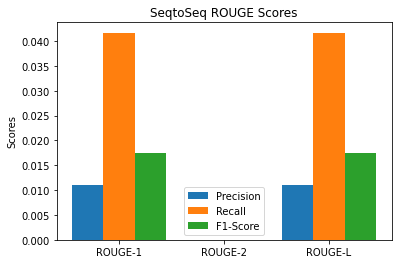

In [ ]:
# Create bar chart of ROUGE scores
labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
precision_scores = [scores["rouge-1"]["p"], scores["rouge-2"]["p"], scores["rouge-l"]["p"]]
recall_scores = [scores["rouge-1"]["r"], scores["rouge-2"]["r"], scores["rouge-l"]["r"]]
f1_scores = [scores["rouge-1"]["f"], scores["rouge-2"]["f"], scores["rouge-l"]["f"]]

x = range(len(labels))
width = 0.3

fig, ax = plt.subplots()
precision_bars = ax.bar(x, precision_scores, width, label='Precision')
recall_bars = ax.bar([i + width for i in x], recall_scores, width, label='Recall')
f1_bars = ax.bar([i + width*2 for i in x], f1_scores, width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('SeqtoSeq ROUGE Scores')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()